## Analyzing Invoice and Receipts Using Textract

Amazon Textract uses machine learning to understand the context of invoices and receipts and automatically extracts data such as invoice or receipt date, invoice or receipt number, item prices, total amount, and payment terms etc. The invoices do not need to be in specific format.

The following is a list of the **standard fields that AnalyzeExpense currently supports**:

- Vendor Name: VENDOR_NAME
- Total: TOTAL
- Receiver Address: RECEIVER_ADDRESS
- Invoice/Receipt Date: INVOICE_RECEIPT_DATE
- Invoice/Receipt ID: INVOICE_RECEIPT_ID
- Payment Terms: PAYMENT_TERMS
- Subtotal: SUBTOTAL
- Due Date: DUE_DATE
- Tax: TAX
- Invoice Tax Payer ID (SSN/ITIN or EIN): TAX_PAYER_ID
- Item Name: ITEM_NAME
- Item Price: PRICE
- Item Quantity: QUANTITY

If the invoice and receipt has other information and you would like to extract those information, you can use Textract Query to ask natural language questions to get the answer.

In [ ]:
!pip install boto3 --upgrade
!pip install awscli --upgrade
!pip install botocore --upgrade

In [ ]:
!pip install amazon-textract-response-parser --upgrade

In [2]:
import boto3
from PIL import Image
import json
import pandas as pd
import time
import requests
import urllib.parse as urlparse
import html
import sagemaker

s3=boto3.resource('s3')
region = boto3.session.Session().region_name
role = sagemaker.get_execution_role()

#-- Amazon Textract client
textract = boto3.client('textract', region_name=region)

In [3]:
#-- Bucket
s3BucketName = "my-projects-abhi-2022"   # create a bucket and change to your bucket name

Let's copy some invoices and receipts to our S3 bucket. 

In [4]:
!aws s3 cp ./Data s3://{s3BucketName}/Textract/invoices_processing_workshop/ --recursive

upload: Data/invoice_1.png to s3://my-projects-abhi-2022/Textract/invoices_processing_workshop/invoice_1.png
upload: Data/receipt_0.png to s3://my-projects-abhi-2022/Textract/invoices_processing_workshop/receipt_0.png
upload: Data/invoice_0.png to s3://my-projects-abhi-2022/Textract/invoices_processing_workshop/invoice_0.png
upload: Data/receipt_02.png to s3://my-projects-abhi-2022/Textract/invoices_processing_workshop/receipt_02.png


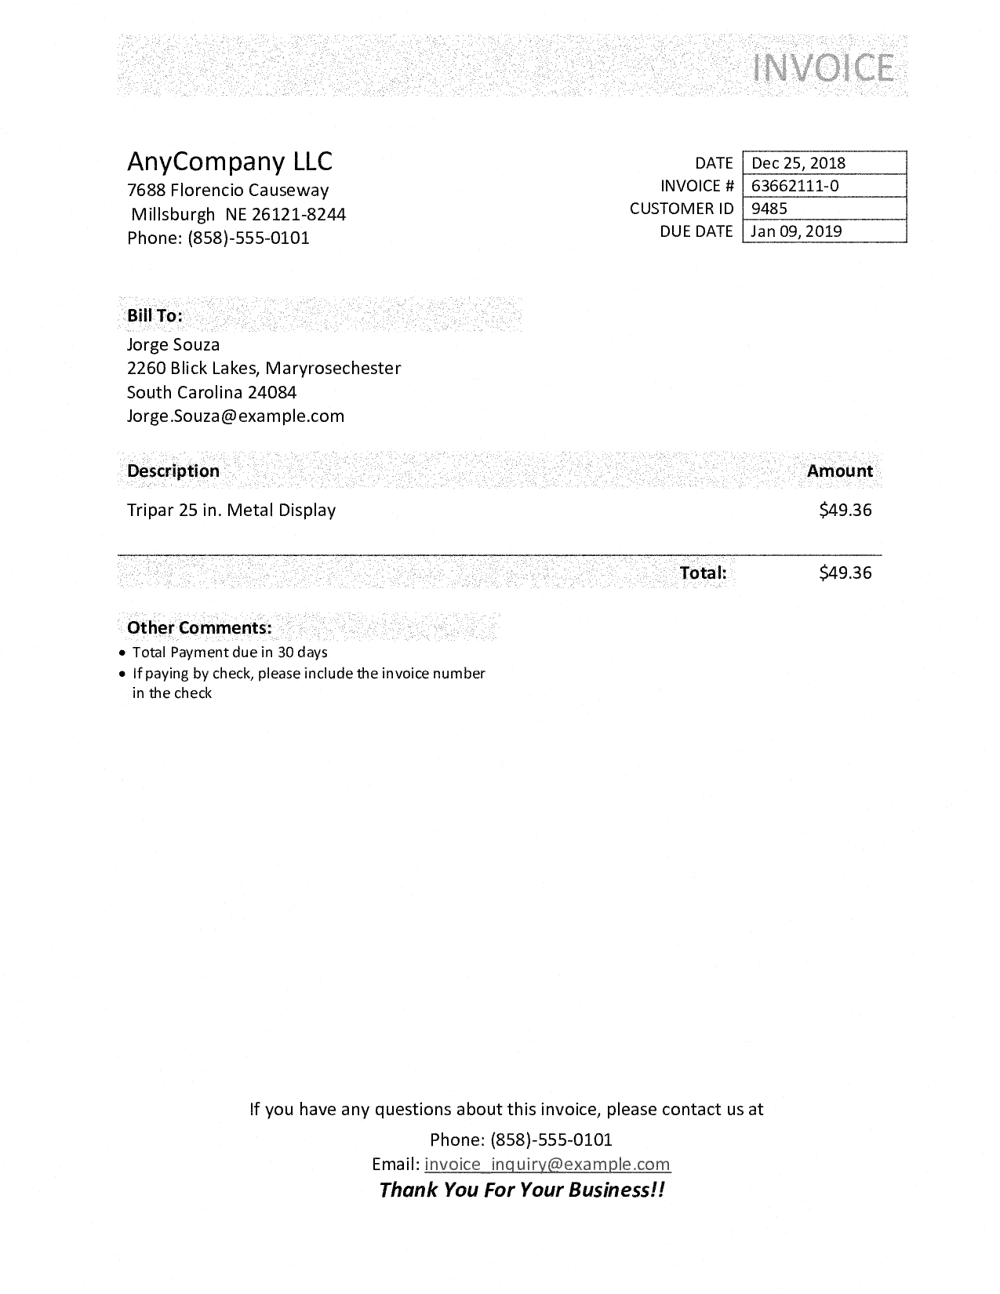

In [45]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

documentName = "Textract/invoices_processing_workshop/invoice_1.png"  # change to S3 key of your document and remove the bucket name

# open it directly
with fs.open("s3://" + s3BucketName+"/" + documentName) as f:
    img=Image.open(f)
    basewidth = 1000
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.BICUBIC)
    display(img)

### Using Amazon Textract AnalyzeExpense and Textract Query

In [46]:
role

'arn:aws:iam::462768798410:role/service-role/AmazonSageMaker-ExecutionRole-20211124T102774'

Before you can call the Textract API, you will need to give necessary access to the SageMaker role to call textract APIs. Go to IAM > roles > search for your role > click on the role > `Add permission` > `Attach policies`. Find the required policies and give full access (just for this lab).

In [47]:
%%time

#-- Call Amazon Textract AnalyzeExpense
response = textract.analyze_expense(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

CPU times: user 20.1 ms, sys: 3.46 ms, total: 23.6 ms
Wall time: 1.98 s


In [48]:
summary_entities_values = []
summary_fields = []
expense_item = []

for expense_doc in response["ExpenseDocuments"]:
    for field in expense_doc["SummaryFields"]:
        kvs = {}
        if "LabelDetection" in field:
            if "ValueDetection" in field:
                kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
        else:
            kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
        summary_entities_values.append(kvs.copy())
        kvs = None

    for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for field in line_items["LineItemExpenseFields"]:
                    kvs = {}
                    if "LabelDetection" in field:
                        if "ValueDetection" in field:
                            kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
                    else:
                        kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
                    expense_item.append(kvs.copy())
                    kvs = None
print("Summary Items:\n")
print(*summary_entities_values, sep='\n')
print("\nExpense Items:\n")
print(*expense_item, sep='\n')

Summary Items:

{'Bill To:': 'Jorge Souza, 2260 Blick Lakes, Maryrosechester, South Carolina 24084'}
{'STREET': '2260 Blick Lakes,'}
{'CITY': 'Maryrosechester'}
{'STATE': 'South Carolina'}
{'ZIP_CODE': '24084'}
{'NAME': 'Jorge Souza'}
{'ADDRESS_BLOCK': '2260 Blick Lakes, Maryrosechester, South Carolina 24084'}
{'ADDRESS': 'AnyCompany LLC, 7688 Florencio Causeway, Millsburgh NE 26121-8244'}
{'STREET': '7688 Florencio Causeway'}
{'CITY': 'Millsburgh'}
{'STATE': 'NE'}
{'ZIP_CODE': '26121-8244'}
{'NAME': 'AnyCompany LLC'}
{'ADDRESS_BLOCK': '7688 Florencio Causeway, Millsburgh NE 26121-8244'}
{'CUSTOMER ID': '9485'}
{'DUE DATE': 'Jan 09, 2019'}
{'DATE': 'Dec 25, 2018'}
{'INVOICE #': '63662111-0'}
{'Bill To:': 'Jorge Souza, 2260 Blick Lakes, Maryrosechester, South Carolina 24084'}
{'RECEIVER_NAME': 'Jorge Souza'}
{'Total:': '$49.36'}
{'VENDOR_ADDRESS': 'AnyCompany LLC, 7688 Florencio Causeway, Millsburgh NE 26121-8244'}
{'VENDOR_NAME': 'AnyCompany LLC'}
{'Phone:': '(858)-555-0101'}
{'Phone:'

### Using Textract Query to extract additional information

We can use Textract Query to extract additional information from the document e.g. merchant address

In [18]:
response_query = textract.analyze_document(
            Document={'S3Object': {'Bucket': s3BucketName, 'Name': documentName}},
            FeatureTypes=["QUERIES"],
            QueriesConfig={
                    'Queries': [
                        {
                            'Text': 'what is the merchant address',
                            'Alias': 'merchant_address'
                        },
                    ]
                }
            )

In [19]:
%store response_query

Stored 'response_query' (dict)


In [20]:
#print(json.dumps(response, indent=4))

In [21]:
import trp.trp2 as t2
d = t2.TDocumentSchema().load(response_query)
page = d.pages[0]
query_answers = d.get_query_answers(page=page)
for item in query_answers:
    print(item[1],": ", item[2])
    if item[1]=='merchant_address':
        merchant_address = item[2]

merchant_address :  7688 Florencio Causeway Millsburgh NE 26121-8244


In [17]:
merchant_address

'7688 Florencio Causeway Millsburgh NE 26121-8244'

## Analyzing Receipt

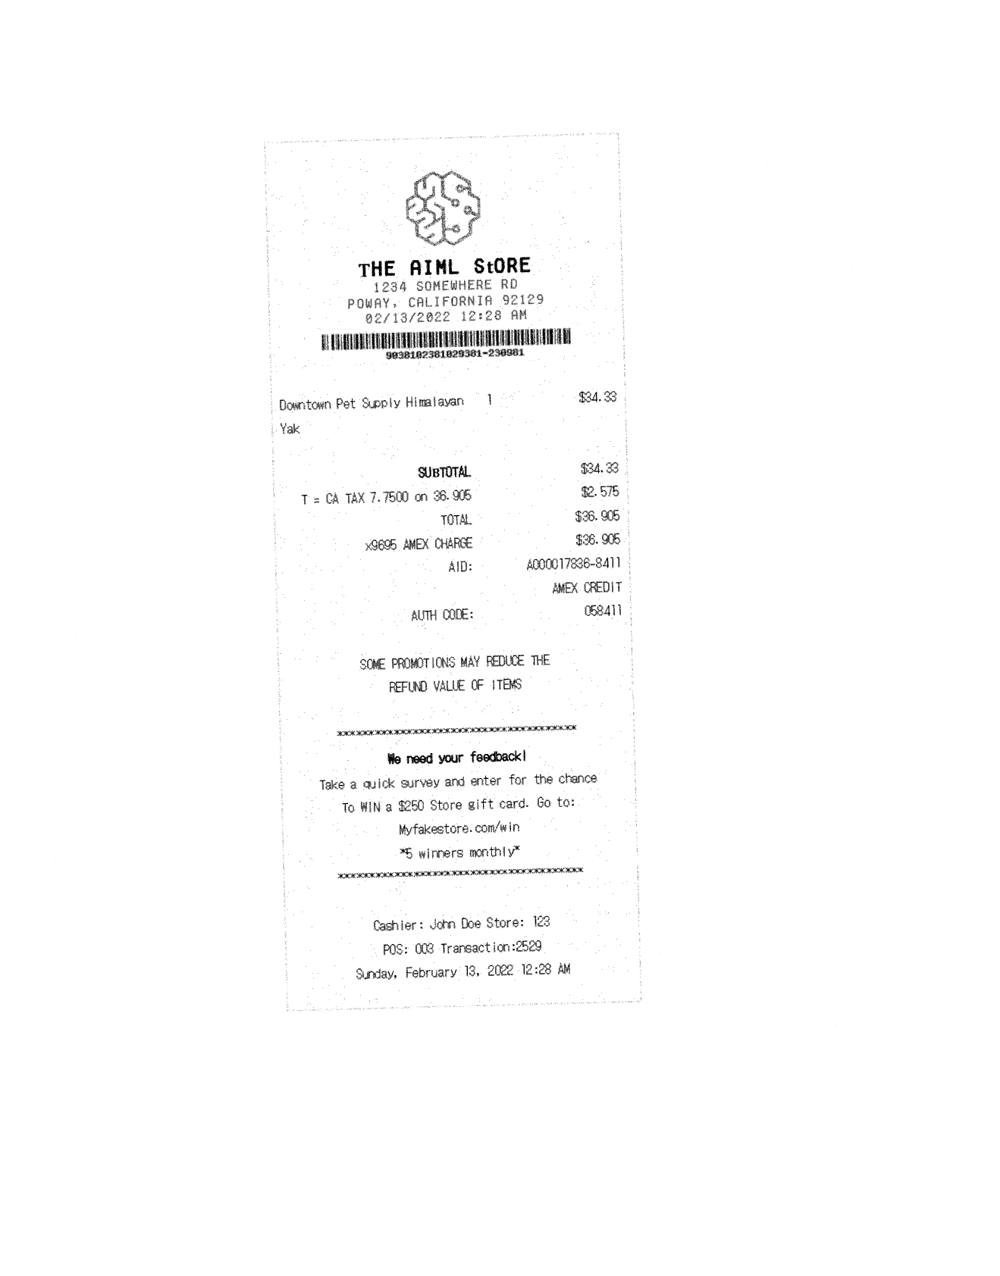

In [55]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

documentName = "Textract/invoices_processing_workshop/receipt_0.png"

# open it directly
with fs.open("s3://" + s3BucketName + "/" + documentName) as f:
    img=Image.open(f)
    basewidth = 1000
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.BICUBIC)
    display(img)

In [56]:
#-- Call Amazon Textract AnalyzeExpense
response_receipt = textract.analyze_expense(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

In [24]:
%store response_receipt

Stored 'response_receipt' (dict)


Now, we will extract the **key-value pairs** from the response_receipt

In [57]:
summary_entities_values = []
summary_fields = []
expense_item = []

for expense_doc in response_receipt["ExpenseDocuments"]:
    for field in expense_doc["SummaryFields"]:
        kvs = {}
        if "LabelDetection" in field:
            if "ValueDetection" in field:
                kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
        else:
            kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
        summary_entities_values.append(kvs.copy())
        kvs = None

    for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for field in line_items["LineItemExpenseFields"]:
                    kvs = {}
                    if "LabelDetection" in field:
                        if "ValueDetection" in field:
                            kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
                    else:
                        kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
                    expense_item.append(kvs.copy())
                    kvs = None
print("Summary Items:\n")
print(*summary_entities_values, sep='\n')
print("\nExpense Items:\n")
print(*expense_item, sep='\n')

Summary Items:

{'ADDRESS': 'THE AIML StORE, 1234 SOMEWHERE RD, POWAY, CALIFORNIA 92129'}
{'STREET': '1234 SOMEWHERE RD'}
{'CITY': 'POWAY,'}
{'STATE': 'CALIFORNIA'}
{'ZIP_CODE': '92129'}
{'NAME': 'THE AIML StORE'}
{'ADDRESS_BLOCK': '1234 SOMEWHERE RD, POWAY, CALIFORNIA 92129'}
{'x9695 AMEX CHARGE': '$36.905'}
{'INVOICE_RECEIPT_DATE': 'February 13, 2022'}
{'INVOICE_RECEIPT_DATE': '02/13/2022'}
{'Transaction:': '2529'}
{'SUBTOTAL': '$34.33'}
{'T = CA TAX 7.7500 on 36. 905': '$2.575'}
{'TOTAL': '$36.905'}
{'VENDOR_ADDRESS': 'THE AIML StORE, 1234 SOMEWHERE RD, POWAY, CALIFORNIA 92129'}
{'VENDOR_NAME': 'THE AIML StORE'}
{'Go to:': 'Myfakestore.com/win'}
{'T = CA': 'CA TAX 7.7500 on 36. 905'}
{'AID:': 'A000017836-8411'}
{'AUTH CODE:': '058411'}
{'Cashier:': 'John Doe'}
{'Store:': '123'}
{'POS:': '003'}

Expense Items:

{'ITEM': 'Downtown Pet Supply Himalayan 1, Yak'}
{'PRICE': '$34.33'}
{'EXPENSE_ROW': 'Downtown Pet Supply Himalayan 1 $34.33, Yak'}


You can also use **Textract Query** feature to extract any information

In [58]:
response_query_receipt = textract.analyze_document(
            Document={'S3Object': {'Bucket': s3BucketName, 'Name': documentName}},
            FeatureTypes=["QUERIES"],
            QueriesConfig={
                    'Queries': [
                        {
                            'Text': 'what is the date',
                            'Alias': 'Date'
                        },
                        {
                            'Text': 'what is the merchant address',
                            'Alias': 'merchant_address'
                        }
                    ]
                }
            )

In [59]:
import trp.trp2 as t2
d = t2.TDocumentSchema().load(response_query_receipt)
page = d.pages[0]
query_answers = d.get_query_answers(page=page)
for item in query_answers:
    print(item[1],": ", item[2])
    if item[1]=='merchant_address':
        merchant_address = item[2]

merchant_address :  1234 SOMEWHERE RD POWAY, CALIFORNIA 92129
Date :  02/13/2022


In [60]:
state = merchant_address.split(" ")[-2] +' '+ merchant_address.split(" ")[-1]
state

'CALIFORNIA 92129'

### Extracting Currency from location service

**Before you can use Amazon location service, you need to ensure that you have added geo search access to SageMaker role**

In [61]:
# Using Amazon Location Service. 
        
client = boto3.client('location')
country_api = client.search_place_index_for_text(IndexName='ExamplePlaceIndex', MaxResults=1, Text=state)
if country_api['Results'] and country_api['Results'][0]['Relevance'] > 0.8:
    country=country_api['Results'][0]['Place']['Country']
    print("country from Amazon location API:", country)
    if country =='USA':
        currency = 'USD'
        print("Currency: ",currency)

country from Amazon location API: USA
Currency:  USD


### Let's try out another receipt..

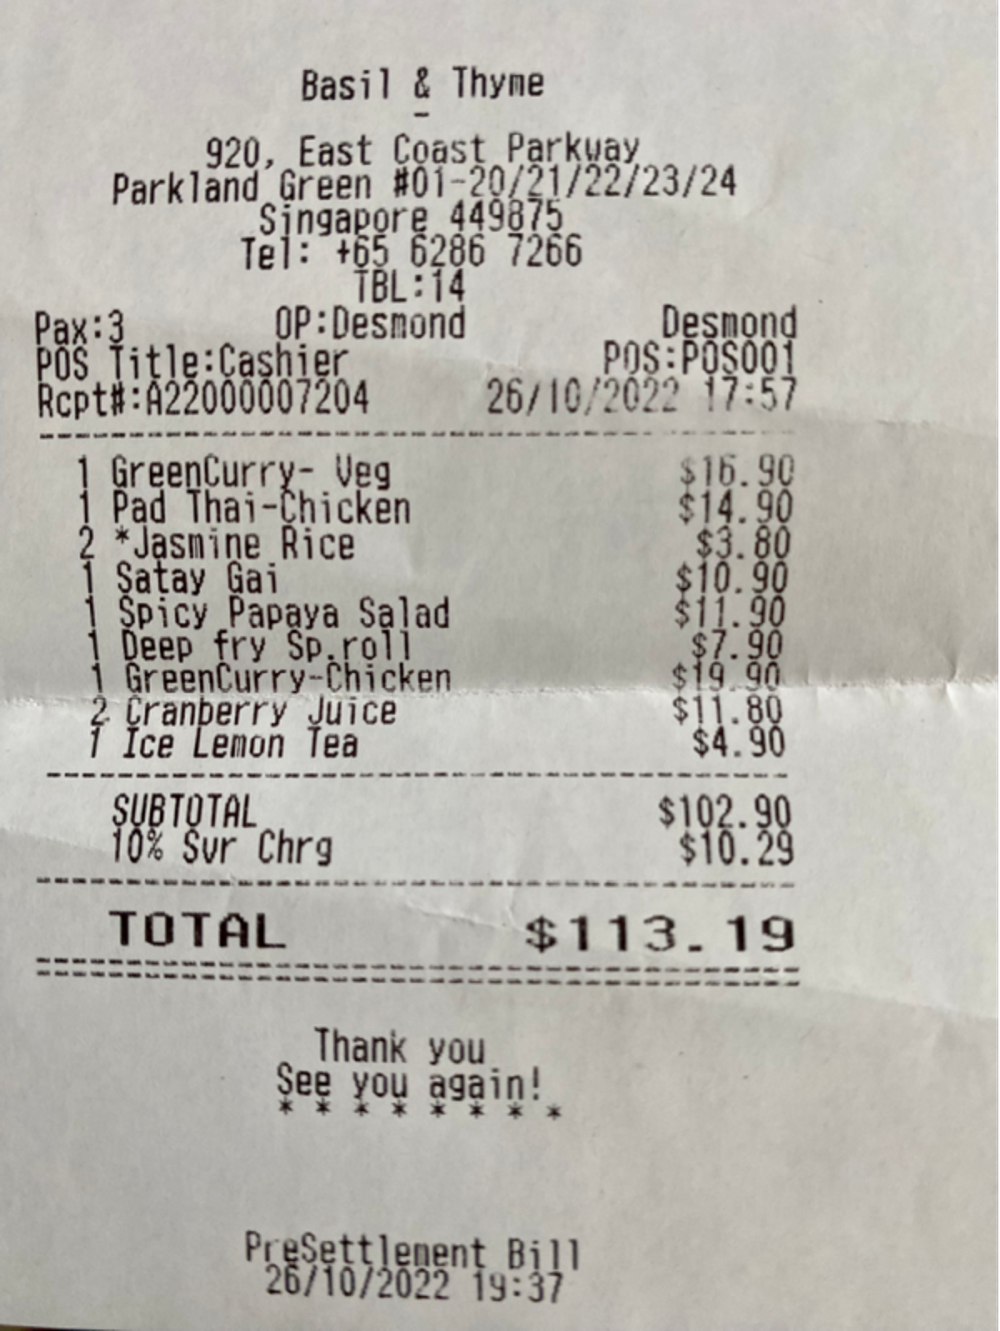

In [33]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

documentName = "Textract/invoices_processing_workshop/receipt_02.png"

# open it directly
with fs.open("s3://" + s3BucketName + "/" + documentName) as f:
    img=Image.open(f)
    basewidth = 1000
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.BICUBIC)
    display(img)

In [34]:
#-- Call Amazon Textract AnalyzeExpense
response_receipt_2 = textract.analyze_expense(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

In [35]:
%store response_receipt_2

Stored 'response_receipt_2' (dict)


In [62]:
summary_entities_values = []
summary_fields = []
expense_item = []

for expense_doc in response_receipt["ExpenseDocuments"]:
    for field in expense_doc["SummaryFields"]:
        kvs = {}
        if "LabelDetection" in field:
            if "ValueDetection" in field:
                kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
        else:
            kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
        summary_entities_values.append(kvs.copy())
        kvs = None

    for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for field in line_items["LineItemExpenseFields"]:
                    kvs = {}
                    if "LabelDetection" in field:
                        if "ValueDetection" in field:
                            kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
                    else:
                        kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"].replace("\n",", ")
                    expense_item.append(kvs.copy())
                    kvs = None
print("Summary Items:\n")
print(*summary_entities_values, sep='\n')
print("\nExpense Items:\n")
print(*expense_item, sep='\n')

Summary Items:

{'ADDRESS': 'Basil & Thyme, 920, East Coast Parkway, Parkland Green 00-20/21/22/23/24, Singapore 449875'}
{'STREET': '920, East Coast Parkway, Parkland Green 00-20/21/22/23/24'}
{'ZIP_CODE': '449875'}
{'COUNTRY': 'Singapore'}
{'NAME': 'Basil & Thyme'}
{'ADDRESS_BLOCK': '920, East Coast Parkway, Parkland Green 00-20/21/22/23/24, Singapore 449875'}
{'INVOICE_RECEIPT_DATE': '26/10/2022'}
{'INVOICE_RECEIPT_DATE': '26/10/2022 19:'}
{'Rcpt#:': 'A22000007204'}
{'10% Svr Chrg': '$10.29'}
{'SUBTOTAL': '$102.90'}
{'TOTAL': '$113.19'}
{'VENDOR_ADDRESS': 'Basil & Thyme, 920, East Coast Parkway, Parkland Green 00-20/21/22/23/24, Singapore 449875'}
{'VENDOR_NAME': 'Basil & Thyme'}
{'Tel:': '+65 6286 7266'}
{'TBL:': '14'}
{'Pax:': '3'}
{'OP:': 'Desmond'}
{'POS Title:': 'Cashier'}
{'POS:': 'P0S001'}
{'Svr Chrg': '10%'}

Expense Items:

{'ITEM': 'GreenCurry- Veg'}
{'PRICE': '$16.90'}
{'EXPENSE_ROW': 'GreenCurry- Veg $16.90'}
{'ITEM': 'Pad Thai-Chicken'}
{'PRICE': '$14.90'}
{'EXPENSE_ROW

## Large scale document processing with Amazon Textract

This reference architecture shows how you can extract text and data from documents at scale using Amazon Textract. Below are some of the key attributes of the reference architecture:

- Process incoming documents to an Amazon S3 bucket.
- Process large backfill of existing documents in an Amazon S3 bucket.
- Serverless, highly available and highly scalable architecture.
- Easily handle spiky workloads.
- Pipelines to support both Sync and Async APIs of Amazon Textract.
- Sample implementation which takes advantage of AWS Cloud Development Kit (CDK) to define infrastructure in code and provision it through CloudFormation.

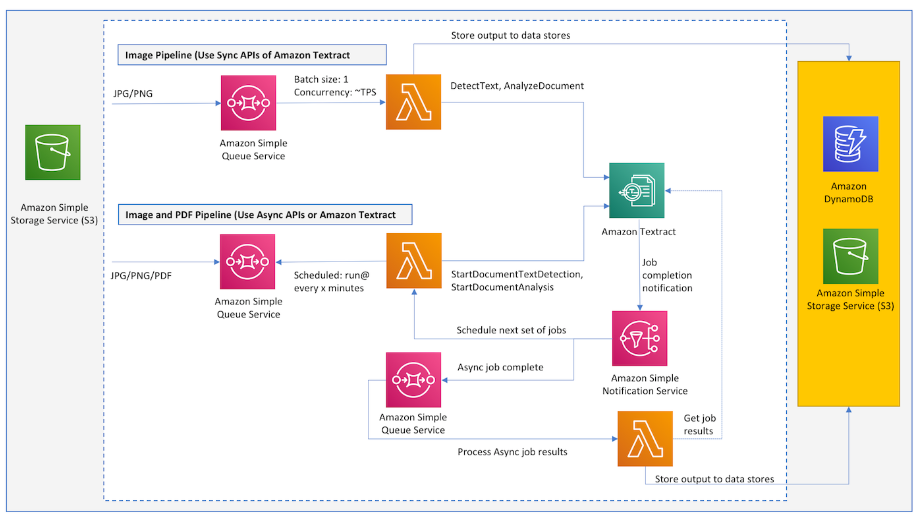

### Image pipeline (Use Sync APIs of Amazon Textract)

- The process starts as a message is sent to an Amazon SQS queue to analyze a document.
- A Lambda function is invoked synchronously with an event that contains queue message.
- Lambda function then calls Amazon Textract and store result in different datastores for example DynamoDB, S3 or Elasticsearch.

### Image and PDF pipeline (Use Async APIs of Amazon Textract)

- The process starts when a message is sent to an SQS queue to analyze a document.
- A job scheduler lambda function runs at certain frequency for example every 5 minutes and poll for messages in the SQS queue.
- For each message in the queue it submits an Amazon Textract job to process the document and continue submitting these jobs until it reaches the maximum limit of concurrent jobs in your AWS account.
- As Amazon Textract is finished processing a document it sends a completion notification to an SNS topic.
- SNS then triggers the job scheduler lambda function to start next set of Amazon Textract jobs.
- SNS also sends a message to an SQS queue which is then processed by a Lambda function to get results from Amazon Textract and store them in a relevant dataset for example DynamoDB, S3 or Elasticsearch.
Your pipeline runs at maximum throughput based on limits on your account. If needed you can get limits raised for concurrent jobs and pipeline automatically adapts based on new limits.


### Steps to implement this architecture

We will use cloud9 here for deployment of this architecture. Open cloud9 from AWS console, select an EC2 instance "t2.large" and create the environment.

- Once the environment is created, open corresponding IDE
- In the terminal, check whether node.js is installed by `node --version`
- If node.js is not installed, you can install by `curl -o- https://raw.githubusercontent.com/creationix/nvm/v0.33.0/install.sh | bash`
- Next, install AWS CLI by `pip install awscli --upgrade`
- Now clone the repo by `git clone https://github.com/aws-samples/amazon-textract-serverless-large-scale-document-processing.git`
- In the terminal, go to the directory "textract-pipeline"
- Run `cdk bootstrap`
- Run `cdk deploy`

### Test incoming documents

- Go to the Amazon S3 bucket "textractpipeline-documentsbucketxxxx" created by the stack and upload few sample documents (jpg/jpeg, png, pdf).
- You will see output files generated for each document with a folder name "{filename}-analysis" (refresh Amazon S3 bucket to see these results).

### Source code

- s3batchproc.py Lambda function that handles event from S3 Batch operation job.
- s3proc.py Lambda function that handles s3 event for an object creation.
- docproc.py Lambda function that push documents to queues for sync or async pipelines.
- syncproc.py Lambda function that takes documents from a queue and process them using sync APIs.
- asyncproc.py Lambda function that takes documents from a queue and start async Amazon Textract jobs.
- jobresultsproc.py Lambda function that process results for a completed Amazon Textract async job.
- textract-pipeline-stack.ts CDK code to define infrastrucure including IAM roles, Lambda functions, SQS queues etc.


## Textract Quotas

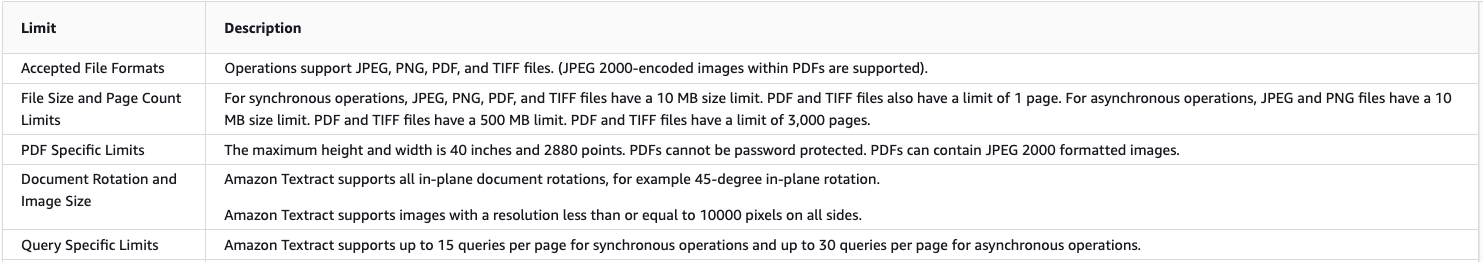

For **Transaction per second (TPS), the default quota is 1 for Singapore region**, but it can be increased upon request by simply opening a ticket using AWS console (https://ap-northeast-1.console.aws.amazon.com/servicequotas/home?region=ap-northeast-1)